# Long-Short Strategy for interpretation of GBM results

Understanding why a model predicts a certain outcome is very important for several reasons, including trust, actionability, accountability, and debugging. 

Insights into the nonlinear relationship between features and the outcome uncovered by the model, as well as interactions among features, are also of value when the goal is to learn more about the underlying drivers of the phenomenon under study.

## Imports & Settings

In [1]:
%matplotlib inline

from pathlib import Path
import warnings
from random import randint
import joblib
from itertools import product

import numpy as np
import pandas as pd

import shap
import lightgbm as lgb
from sklearn.inspection import (plot_partial_dependence, 
                                partial_dependence)

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [2]:
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
idx = pd.IndexSlice
np.random.seed(42)

In [3]:
DATA_STORE = Path('../data/assets.h5')

## Retrieve best model parameters

The results used below are created by the notebooks [gbm_trading_signals](05_gbm_trading_signals.ipynb).

In [4]:
with pd.HDFStore('data.h5') as store:
    best_params = store['best_params']

In [5]:
best_params

train_length        1138.0
test_length           63.0
learning_rate          0.1
num_leaves           128.0
feature_fraction       0.3
min_data_in_leaf     250.0
boost_rounds         450.0
Name: 1129, dtype: float64

## Get Training Data

In [6]:
data = pd.read_hdf('data.h5', 'model_data').sort_index()
data = data.loc[idx[:, '2012':'2019'], :]

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1896265 entries, ('AAON', Timestamp('2012-01-02 00:00:00')) to ('ZWS', Timestamp('2019-12-31 00:00:00'))
Data columns (total 35 columns):
 #   Column           Dtype  
---  ------           -----  
 0   dollar_vol       float64
 1   dollar_vol_rank  float64
 2   rsi              float64
 3   bb_high          float64
 4   bb_low           float64
 5   SAR              float64
 6   NATR             float64
 7   ATR              float64
 8   PPO              float64
 9   MACD             float64
 10  sector           int32  
 11  r01              float64
 12  r05              float64
 13  r10              float64
 14  r21              float64
 15  r42              float64
 16  r63              float64
 17  r01dec           float64
 18  r05dec           float64
 19  r10dec           float64
 20  r21dec           float64
 21  r42dec           float64
 22  r63dec           float64
 23  r01q_sector      float64
 24  r05q_sector      float64
 2

## Create Binary Data

In [8]:
dates = sorted(data.index.get_level_values('date').unique())

In [9]:
train_dates = dates[-int(best_params.train_length):]

In [10]:
data = data.loc[idx[:, train_dates], :]

In [11]:
labels = sorted(data.filter(like='_fwd').columns)
features = data.columns.difference(labels).tolist()

In [12]:
lookahead = 21
label = f'r{lookahead:02}_fwd'

In [13]:
categoricals = ['year', 'month', 'sector', 'weekday']

In [14]:
lgb_train = lgb.Dataset(data=data[features],
                       label=data[label],
                       categorical_feature=categoricals,
                       free_raw_data=False)

## Train LightGBM Model

In [15]:
params = dict(boosting='gbdt', objective='regression', verbose=-1)

In [16]:
train_params = ['learning_rate', 'num_leaves', 'feature_fraction', 'min_data_in_leaf']

In [17]:
params.update(best_params.loc[train_params].to_dict())
for p in ['min_data_in_leaf', 'num_leaves']:
    params[p] = int(params[p])

In [18]:
params

{'boosting': 'gbdt',
 'objective': 'regression',
 'verbose': -1,
 'learning_rate': 0.1,
 'num_leaves': 128,
 'feature_fraction': 0.3,
 'min_data_in_leaf': 250}

In [19]:
lgb_model = lgb.train(params=params,
                  train_set=lgb_train,
                  num_boost_round=int(best_params.boost_rounds))

## Compute Feature Importance

Attribute feature importance values to each input variable. These feature importance values. Gain a higher-level perspective on how the model makes predictions.

These values are available using the trained model's .feature_importance() method with the corresponding importance_type parameter. 

In [20]:
def get_feature_importance(model, importance_type='split'):
    fi = pd.Series(model.feature_importance(importance_type=importance_type), 
                   index=model.feature_name())
    return fi/fi.sum()

In [21]:
feature_importance = (get_feature_importance(lgb_model).to_frame('Split').
                      join(get_feature_importance(lgb_model, 'gain').to_frame('Gain')))

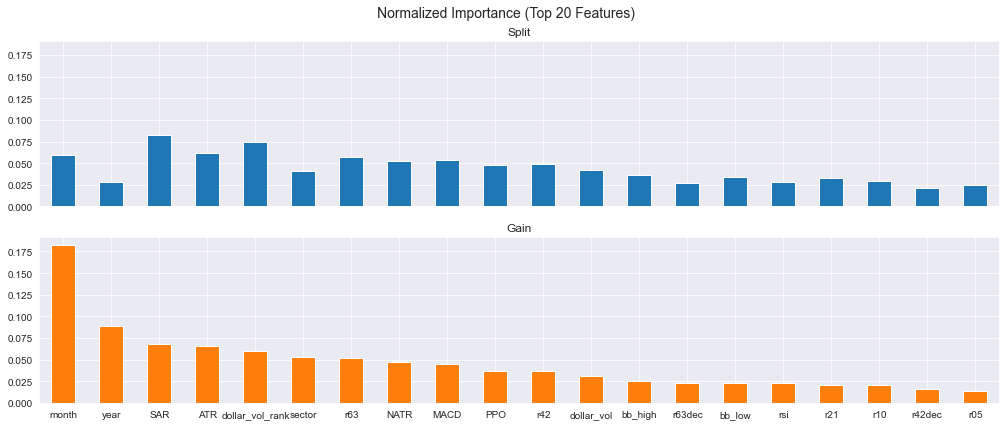

In [22]:
(feature_importance
 .nlargest(20, columns='Gain')
 .sort_values('Gain', ascending=False)
 .plot
 .bar(subplots=True,
      layout=(2, 1),
      figsize=(14, 6),
      legend=False,
      sharey=True,
      rot=0))
plt.suptitle('Normalized Importance (Top 20 Features)', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=.9);

## SHAP Values

SHAP values unify ideas from collaborative game theory and local explanations, and have been shown to be theoretically optimal, consistent, and locally accurate based on expectations.

### Summary Plot

A simple average across all samples that resembles the global feature-importance measures computed previously and a scatter graph to display the impact of every feature for every sample.

In [23]:
X = data[features].sample(n=1000)

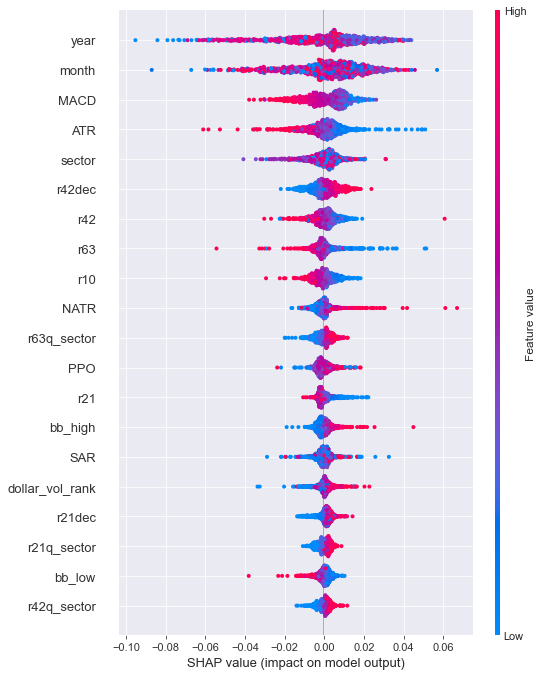

In [24]:
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X=X)

shap.summary_plot(shap_values, X, show=False)
plt.tight_layout();

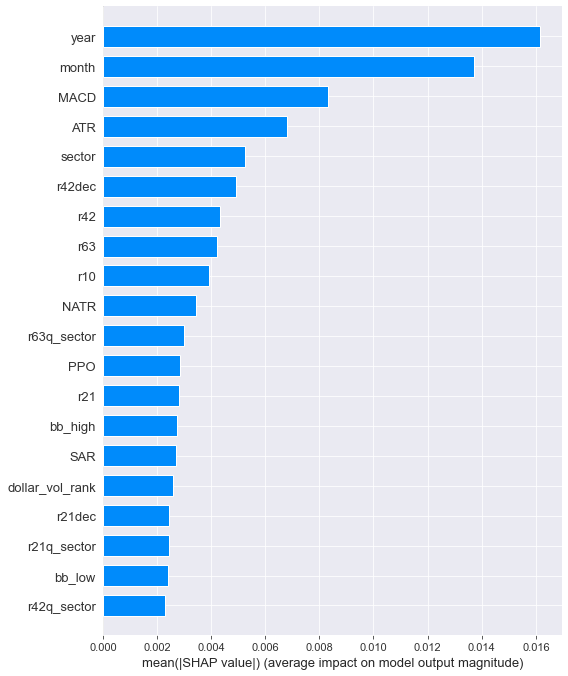

In [25]:
shap.summary_plot(shap_values, X, plot_type="bar",show=False)
plt.tight_layout();

### Feature Interaction

### Force Plots

The following force plot shows the cumulative impact of various features and their values on the model output.

Features highlighted in red increase the output, blue reduces the output.

Obtain a detailed breakdown of how the model arrived at a specific prediction:

In [26]:
i = randint(0, len(X))
shap.force_plot(explainer.expected_value, shap_values[i,:], X.iloc[i,:])

The following plot shows the force plots for the first 1,000 observations rotated by 90 degrees, stacked horizontally, and ordered by the impact of different features on the outcome for the given observation. 

In [27]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X.iloc[:1000])

### Interaction Plot

SHAP values allow us to gain additional insights into the interaction effects between different features by separating these interactions from the main effects. Displays how different values for 1-month returns  affect the outcome (SHAP value on the y axis), differentiated by 3-month returns:

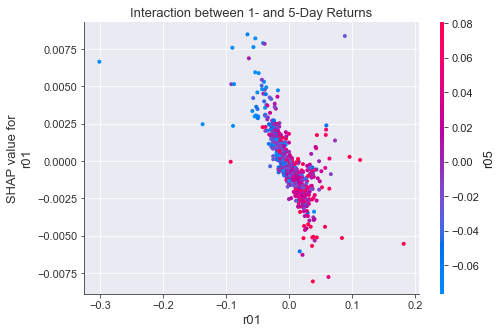

In [28]:
shap.dependence_plot(ind='r01',
                     shap_values=shap_values,
                     features=X,
                     interaction_index='r05',
                     title='Interaction between 1- and 5-Day Returns')

NOTE: Attribution of the influence for variables that are correlated, like in the stock market, makes the attribution of influence of a certain feature to the output difficult because the influence can be broken down in several different ways. 